embed dim 4096
interaction_indexes [9, 19, 29, 39]
patch_size 16
Masks shape: torch.Size([1, 100, 224, 224])
Feature dimensions: 100 channels, 224x224 spatial
Applying PCA...
PCA explained variance ratio: [0.72470206 0.13090834 0.07604982]
Total variance explained: 93.17%


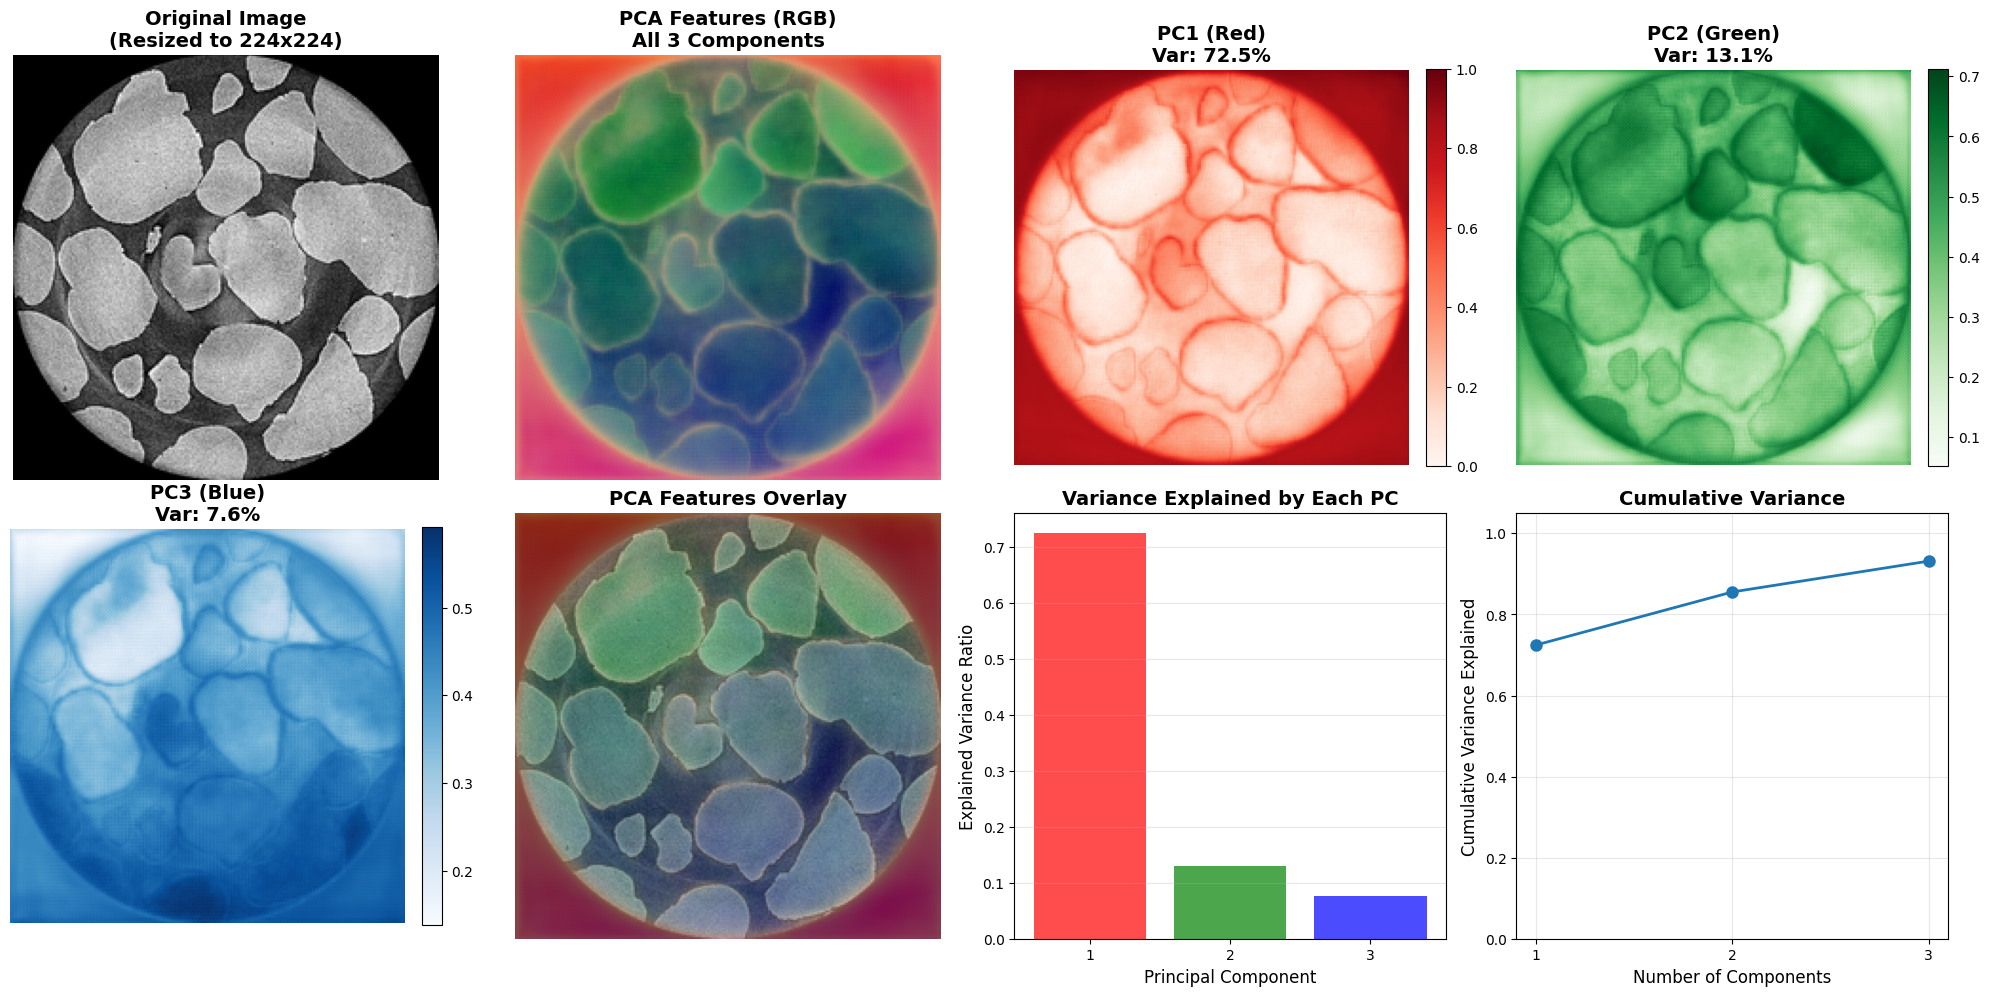

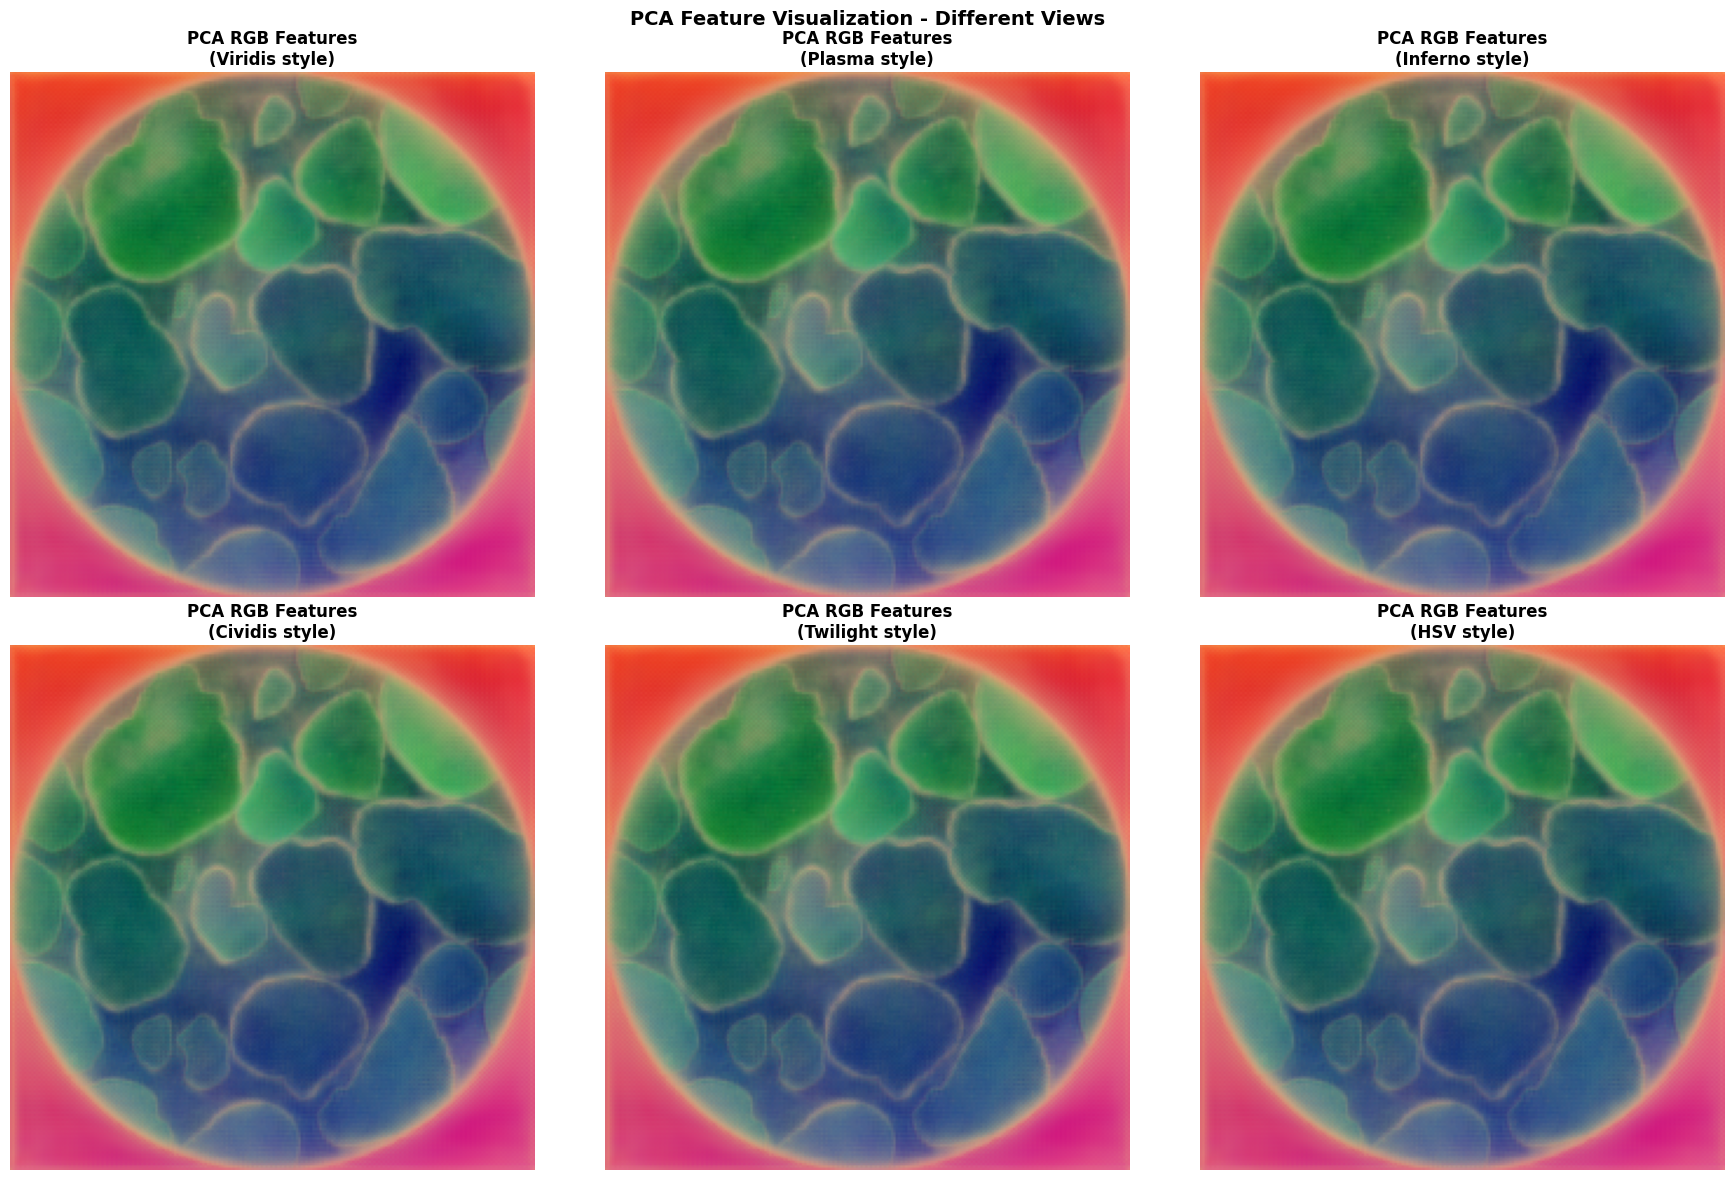


PCA Component Statistics:
PC1: min=-114.588, max=164.225, mean=0.000, std=78.249
PC2: min=-100.404, max=84.066, mean=-0.000, std=33.257
PC3: min=-75.950, max=50.440, mean=0.000, std=25.348

Shape of PCA output: (224, 224, 3)
Total explained variance: 93.17%


In [7]:
import sys
REPO_DIR = "./dinov3"
sys.path.append(REPO_DIR)
import os
os.environ["TORCH_HOME"] = "./.cache"
from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
from sklearn.decomposition import PCA

def get_img():
    import requests
    path = "20240425_112716_nist-sand-30-100_27keV_z8mm_n2625_00000.png"
    image = Image.open(path).convert("RGB")
    return image

def make_transform(resize_size: int | list[int] = 768):
    to_tensor = v2.ToImage()
    resize = v2.Resize((resize_size, resize_size), antialias=True)
    to_float = v2.ToDtype(torch.float32, scale=True)
    normalize = v2.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return v2.Compose([to_tensor, resize, to_float, normalize])

# Load model
segmentor = torch.hub.load(
    REPO_DIR, 
    'dinov3_vit7b16_ms', 
    source="local", 
    weights="./dinov3_vit7b16_ade20k_m2f_head-bf307cb1.pth", 
    backbone_weights="./dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth"
)

img_size = 896
img = get_img()
transform = make_transform(img_size)

with torch.inference_mode():
    with torch.autocast('cuda', dtype=torch.bfloat16):
        batch_img = transform(img)[None]
        output = segmentor(batch_img)

# Extract masks
pred_masks = output['pred_masks']  # Shape: [1, 100, H, W]
print(f"Masks shape: {pred_masks.shape}")

# Remove batch dimension and move to CPU
masks = pred_masks[0].cpu().float().numpy()  # Shape: [100, H, W]
n_channels, h, w = masks.shape

print(f"Feature dimensions: {n_channels} channels, {h}x{w} spatial")

# Resize original image to match mask dimensions
img_resized = img.resize((w, h), Image.LANCZOS)

# Reshape for PCA: [n_channels, h*w] -> [h*w, n_channels]
masks_flat = masks.reshape(n_channels, -1).T  # Shape: [h*w, 100]

print("Applying PCA...")
# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
masks_pca = pca.fit_transform(masks_flat)  # Shape: [h*w, 3]

# Reshape back to image: [h*w, 3] -> [h, w, 3]
masks_pca_img = masks_pca.reshape(h, w, 3)

# Normalize to [0, 1] for visualization
masks_pca_img_norm = masks_pca_img - masks_pca_img.min()
masks_pca_img_norm = masks_pca_img_norm / (masks_pca_img_norm.max() + 1e-8)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Create visualization
fig = plt.figure(figsize=(20, 10))

# 1. Original Image (resized to match masks)
plt.subplot(2, 4, 1)
plt.imshow(img_resized)
plt.title(f"Original Image\n(Resized to {w}x{h})", fontsize=14, fontweight='bold')
plt.axis("off")

# 2. PCA RGB Visualization
plt.subplot(2, 4, 2)
plt.imshow(masks_pca_img_norm)
plt.title("PCA Features (RGB)\nAll 3 Components", fontsize=14, fontweight='bold')
plt.axis("off")

# 3. First Principal Component (Red)
plt.subplot(2, 4, 3)
plt.imshow(masks_pca_img_norm[:, :, 0], cmap='Reds')
plt.title(f"PC1 (Red)\nVar: {pca.explained_variance_ratio_[0]:.1%}", 
          fontsize=14, fontweight='bold')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

# 4. Second Principal Component (Green)
plt.subplot(2, 4, 4)
plt.imshow(masks_pca_img_norm[:, :, 1], cmap='Greens')
plt.title(f"PC2 (Green)\nVar: {pca.explained_variance_ratio_[1]:.1%}", 
          fontsize=14, fontweight='bold')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

# 5. Third Principal Component (Blue)
plt.subplot(2, 4, 5)
plt.imshow(masks_pca_img_norm[:, :, 2], cmap='Blues')
plt.title(f"PC3 (Blue)\nVar: {pca.explained_variance_ratio_[2]:.1%}", 
          fontsize=14, fontweight='bold')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

# 6. PCA RGB overlaid on original image
plt.subplot(2, 4, 6)
plt.imshow(img_resized)
plt.imshow(masks_pca_img_norm, alpha=0.6)
plt.title("PCA Features Overlay", fontsize=14, fontweight='bold')
plt.axis("off")

# 7. Explained variance
plt.subplot(2, 4, 7)
plt.bar(range(1, 4), pca.explained_variance_ratio_, color=['red', 'green', 'blue'], alpha=0.7)
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Explained Variance Ratio", fontsize=12)
plt.title("Variance Explained by Each PC", fontsize=14, fontweight='bold')
plt.xticks([1, 2, 3])
plt.grid(alpha=0.3, axis='y')

# 8. Cumulative variance
plt.subplot(2, 4, 8)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, 4), cumsum, marker='o', linewidth=2, markersize=8)
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Cumulative Variance Explained", fontsize=12)
plt.title("Cumulative Variance", fontsize=14, fontweight='bold')
plt.xticks([1, 2, 3])
plt.grid(alpha=0.3)
plt.ylim([0, 1.05])

plt.tight_layout()
plt.savefig('dinov2_pca_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

# Additional visualization: Different color schemes
fig2, axes = plt.subplots(2, 3, figsize=(18, 12))

color_schemes = [
    ('viridis', 'Viridis'),
    ('plasma', 'Plasma'),
    ('inferno', 'Inferno'),
    ('cividis', 'Cividis'),
    ('twilight', 'Twilight'),
    ('hsv', 'HSV')
]

for idx, (cmap, name) in enumerate(color_schemes):
    ax = axes.flatten()[idx]
    
    # Convert RGB to single channel for colormap
    pca_gray = masks_pca_img_norm.mean(axis=2)
    
    ax.imshow(masks_pca_img_norm)
    ax.set_title(f'PCA RGB Features\n({name} style)', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle('PCA Feature Visualization - Different Views', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('dinov2_pca_colorschemes.png', dpi=150, bbox_inches='tight')
plt.show()

# Print component statistics
print("\nPCA Component Statistics:")
for i in range(3):
    print(f"PC{i+1}: min={masks_pca_img[:, :, i].min():.3f}, "
          f"max={masks_pca_img[:, :, i].max():.3f}, "
          f"mean={masks_pca_img[:, :, i].mean():.3f}, "
          f"std={masks_pca_img[:, :, i].std():.3f}")

print(f"\nShape of PCA output: {masks_pca_img_norm.shape}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")

embed dim 4096
interaction_indexes [9, 19, 29, 39]
patch_size 16
Loading TIFF file: ./20211222_125057_petiole4_00000.tiff
Image loaded: (2560, 2560), mode: RGB


/pscratch/sd/x/xchong/envs/sam3/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Masks shape: torch.Size([1, 100, 224, 224])
Feature dimensions: 100 channels, 224x224 spatial
Applying PCA...
PCA explained variance ratio: [0.8154078  0.08902729 0.06271565]
Total variance explained: 96.72%


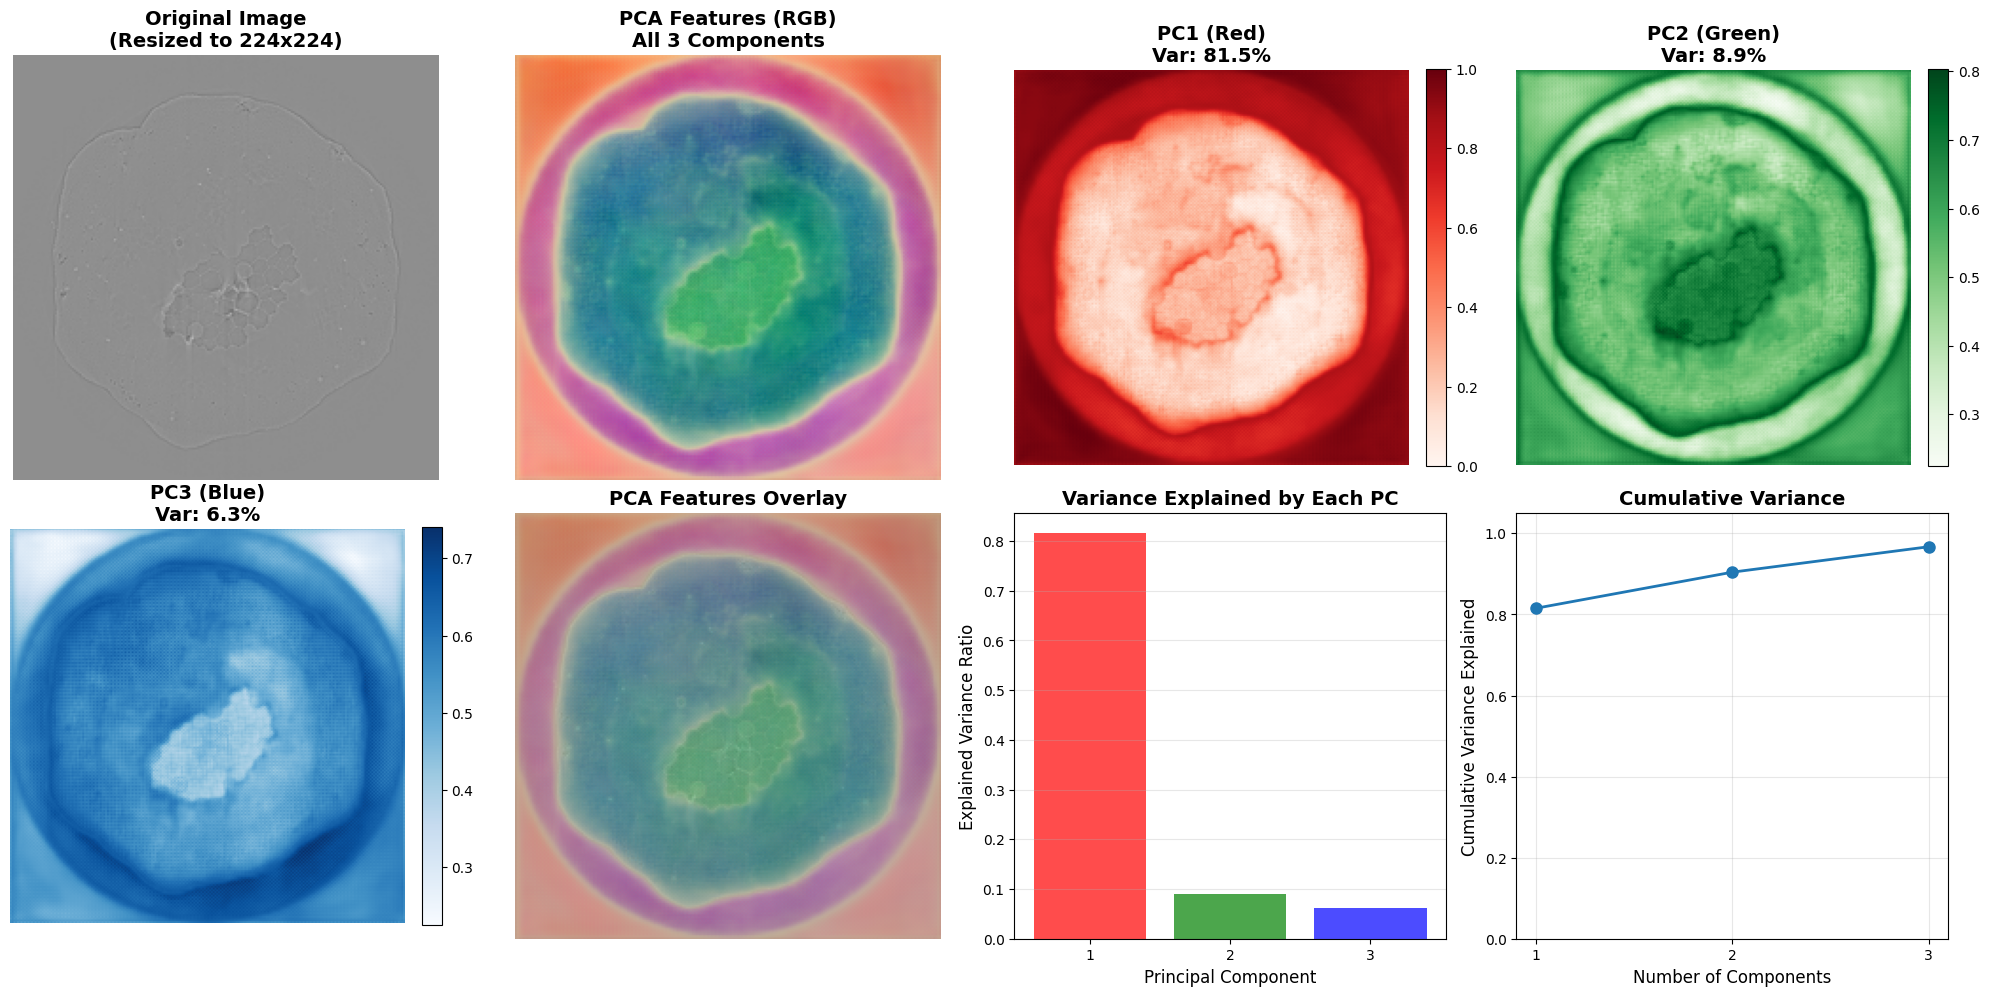

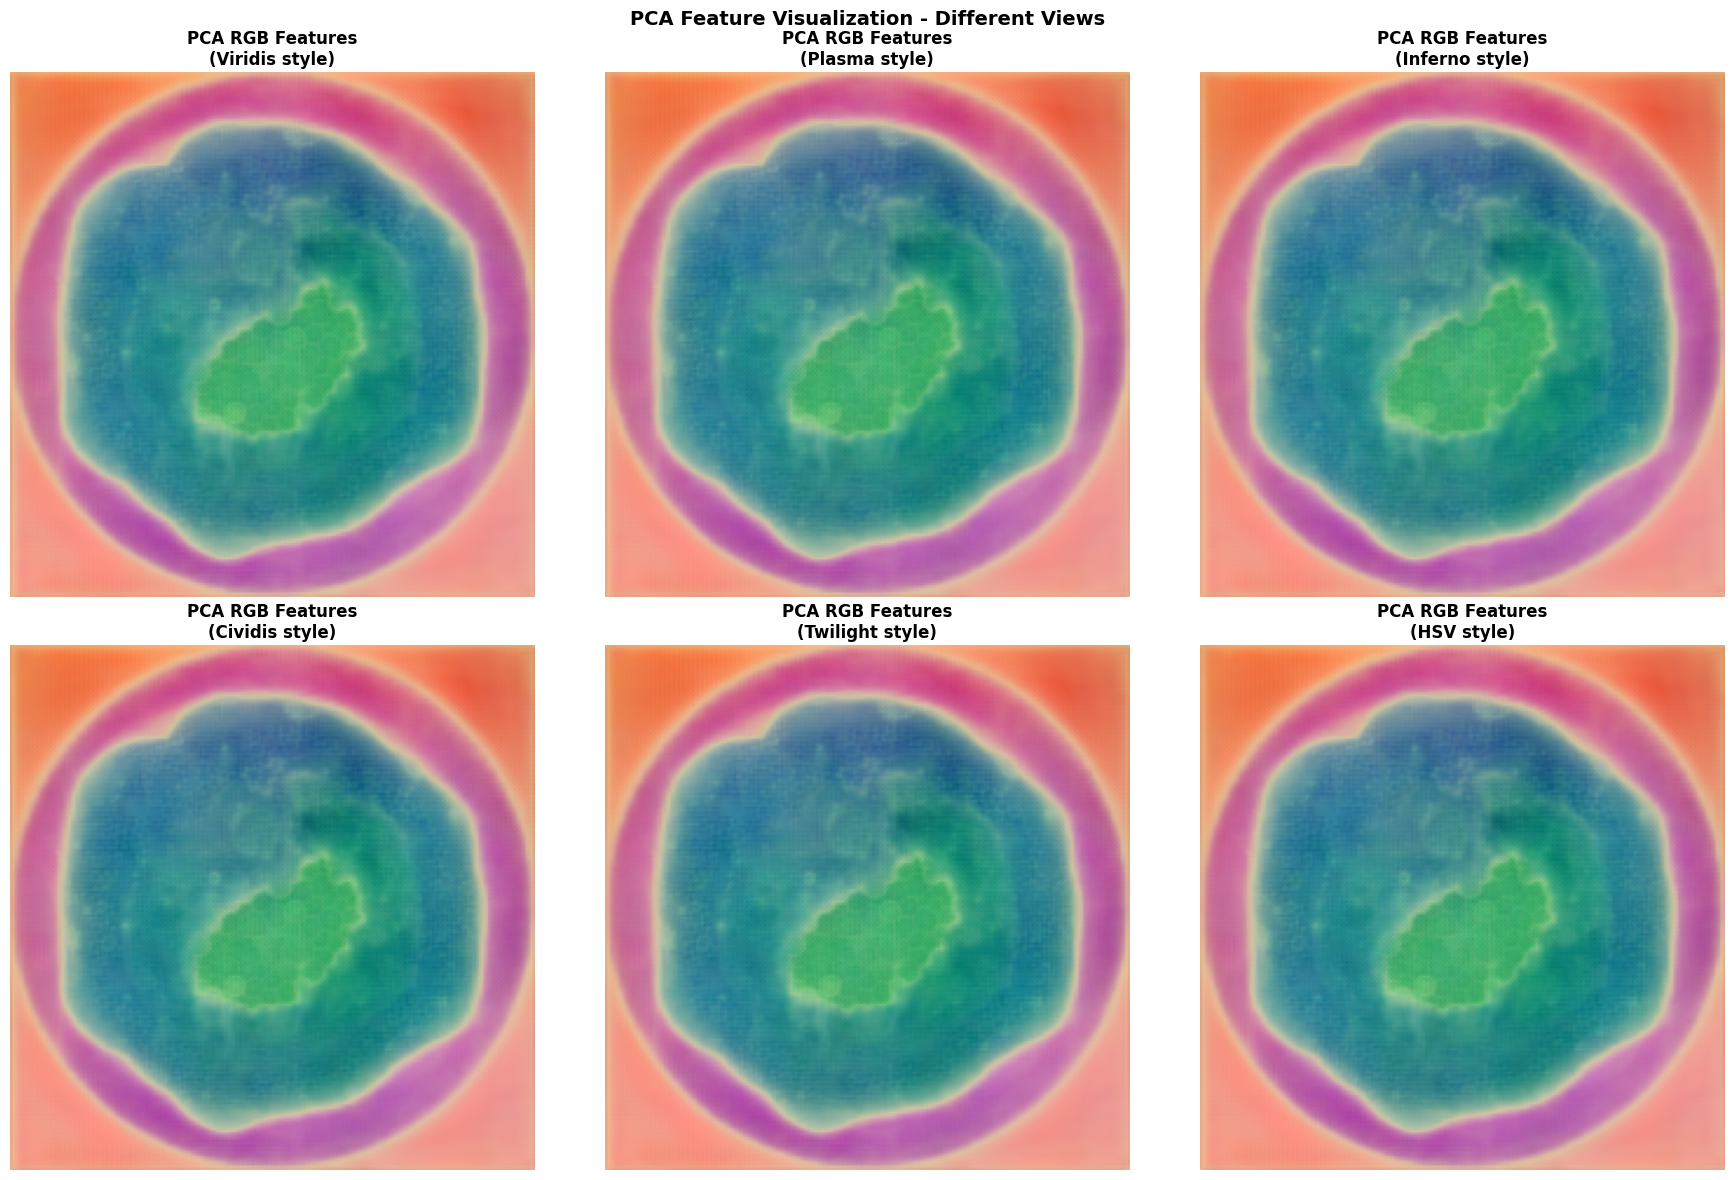


PCA Component Statistics:
PC1: min=-178.619, max=146.882, mean=-0.000, std=103.280
PC2: min=-105.627, max=82.930, mean=-0.000, std=34.126
PC3: min=-105.076, max=62.366, mean=0.000, std=28.643

Shape of PCA output: (224, 224, 3)
Total explained variance: 96.72%


In [3]:
import sys
REPO_DIR = "./dinov3"
sys.path.append(REPO_DIR)
import os
os.environ["TORCH_HOME"] = "./.cache"
from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
from sklearn.decomposition import PCA

def get_img(tiff_path: str):
    """
    Load a TIFF file and convert to RGB.
    Handles both 8-bit and 16-bit TIFF files.
    """
    image = Image.open(tiff_path)
    
    # Convert to numpy array to handle different bit depths
    img_array = np.array(image)
    
    # Normalize based on bit depth
    if img_array.dtype == np.uint16:
        # 16-bit image - normalize to 0-255 range
        img_array = (img_array / 65535.0 * 255).astype(np.uint8)
    elif img_array.dtype == np.uint8:
        # Already 8-bit
        pass
    else:
        # Float or other types - normalize to 0-255
        img_min = img_array.min()
        img_max = img_array.max()
        if img_max > img_min:
            img_array = ((img_array - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            img_array = np.zeros_like(img_array, dtype=np.uint8)
    
    # Convert to PIL Image and ensure RGB
    image = Image.fromarray(img_array)
    
    # Handle different image modes
    if image.mode == 'L':  # Grayscale
        image = image.convert('RGB')
    elif image.mode == 'I' or image.mode == 'F':  # 32-bit integer or float
        image = image.convert('RGB')
    elif image.mode != 'RGB':
        image = image.convert('RGB')
    
    return image

def make_transform(resize_size: int | list[int] = 768):
    to_tensor = v2.ToImage()
    resize = v2.Resize((resize_size, resize_size), antialias=True)
    to_float = v2.ToDtype(torch.float32, scale=True)
    normalize = v2.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return v2.Compose([to_tensor, resize, to_float, normalize])

# ============ MODIFY THIS PATH TO YOUR TIFF FILE ============
TIFF_FILE_PATH = "./20211222_125057_petiole4_00000.tiff"  # Change this to your TIFF file path
# ============================================================

# Load model
segmentor = torch.hub.load(
    REPO_DIR, 
    'dinov3_vit7b16_ms', 
    source="local", 
    weights="./dinov3_vit7b16_ade20k_m2f_head-bf307cb1.pth", 
    backbone_weights="./dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth"
)

img_size = 896

# Load and preprocess the TIFF image
print(f"Loading TIFF file: {TIFF_FILE_PATH}")
img = get_img(TIFF_FILE_PATH)
print(f"Image loaded: {img.size}, mode: {img.mode}")

transform = make_transform(img_size)

with torch.inference_mode():
    with torch.autocast('cuda', dtype=torch.bfloat16):
        batch_img = transform(img)[None]
        output = segmentor(batch_img)

# Extract masks
pred_masks = output['pred_masks']  # Shape: [1, 100, H, W]
print(f"Masks shape: {pred_masks.shape}")

# Remove batch dimension and move to CPU
masks = pred_masks[0].cpu().float().numpy()  # Shape: [100, H, W]
n_channels, h, w = masks.shape

print(f"Feature dimensions: {n_channels} channels, {h}x{w} spatial")

# Resize original image to match mask dimensions
img_resized = img.resize((w, h), Image.LANCZOS)

# Reshape for PCA: [n_channels, h*w] -> [h*w, n_channels]
masks_flat = masks.reshape(n_channels, -1).T  # Shape: [h*w, 100]

print("Applying PCA...")
# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
masks_pca = pca.fit_transform(masks_flat)  # Shape: [h*w, 3]

# Reshape back to image: [h*w, 3] -> [h, w, 3]
masks_pca_img = masks_pca.reshape(h, w, 3)

# Normalize to [0, 1] for visualization
masks_pca_img_norm = masks_pca_img - masks_pca_img.min()
masks_pca_img_norm = masks_pca_img_norm / (masks_pca_img_norm.max() + 1e-8)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Create visualization
fig = plt.figure(figsize=(20, 10))

# 1. Original Image (resized to match masks)
plt.subplot(2, 4, 1)
plt.imshow(img_resized)
plt.title(f"Original Image\n(Resized to {w}x{h})", fontsize=14, fontweight='bold')
plt.axis("off")

# 2. PCA RGB Visualization
plt.subplot(2, 4, 2)
plt.imshow(masks_pca_img_norm)
plt.title("PCA Features (RGB)\nAll 3 Components", fontsize=14, fontweight='bold')
plt.axis("off")

# 3. First Principal Component (Red)
plt.subplot(2, 4, 3)
plt.imshow(masks_pca_img_norm[:, :, 0], cmap='Reds')
plt.title(f"PC1 (Red)\nVar: {pca.explained_variance_ratio_[0]:.1%}", 
          fontsize=14, fontweight='bold')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

# 4. Second Principal Component (Green)
plt.subplot(2, 4, 4)
plt.imshow(masks_pca_img_norm[:, :, 1], cmap='Greens')
plt.title(f"PC2 (Green)\nVar: {pca.explained_variance_ratio_[1]:.1%}", 
          fontsize=14, fontweight='bold')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

# 5. Third Principal Component (Blue)
plt.subplot(2, 4, 5)
plt.imshow(masks_pca_img_norm[:, :, 2], cmap='Blues')
plt.title(f"PC3 (Blue)\nVar: {pca.explained_variance_ratio_[2]:.1%}", 
          fontsize=14, fontweight='bold')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

# 6. PCA RGB overlaid on original image
plt.subplot(2, 4, 6)
plt.imshow(img_resized)
plt.imshow(masks_pca_img_norm, alpha=0.6)
plt.title("PCA Features Overlay", fontsize=14, fontweight='bold')
plt.axis("off")

# 7. Explained variance
plt.subplot(2, 4, 7)
plt.bar(range(1, 4), pca.explained_variance_ratio_, color=['red', 'green', 'blue'], alpha=0.7)
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Explained Variance Ratio", fontsize=12)
plt.title("Variance Explained by Each PC", fontsize=14, fontweight='bold')
plt.xticks([1, 2, 3])
plt.grid(alpha=0.3, axis='y')

# 8. Cumulative variance
plt.subplot(2, 4, 8)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, 4), cumsum, marker='o', linewidth=2, markersize=8)
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Cumulative Variance Explained", fontsize=12)
plt.title("Cumulative Variance", fontsize=14, fontweight='bold')
plt.xticks([1, 2, 3])
plt.grid(alpha=0.3)
plt.ylim([0, 1.05])

plt.tight_layout()
plt.savefig('dinov2_pca_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

# Additional visualization: Different color schemes
fig2, axes = plt.subplots(2, 3, figsize=(18, 12))

color_schemes = [
    ('viridis', 'Viridis'),
    ('plasma', 'Plasma'),
    ('inferno', 'Inferno'),
    ('cividis', 'Cividis'),
    ('twilight', 'Twilight'),
    ('hsv', 'HSV')
]

for idx, (cmap, name) in enumerate(color_schemes):
    ax = axes.flatten()[idx]
    ax.imshow(masks_pca_img_norm)
    ax.set_title(f'PCA RGB Features\n({name} style)', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle('PCA Feature Visualization - Different Views', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('dinov2_pca_colorschemes.png', dpi=150, bbox_inches='tight')
plt.show()

# Print component statistics
print("\nPCA Component Statistics:")
for i in range(3):
    print(f"PC{i+1}: min={masks_pca_img[:, :, i].min():.3f}, "
          f"max={masks_pca_img[:, :, i].max():.3f}, "
          f"mean={masks_pca_img[:, :, i].mean():.3f}, "
          f"std={masks_pca_img[:, :, i].std():.3f}")

print(f"\nShape of PCA output: {masks_pca_img_norm.shape}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")